In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
import time

from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

import pandas as pd
import geopandas as gpd

import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import timedelta
import datetime
from datetime import timedelta, date, datetime

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import imageio
from pygifsicle import optimize

plt.style.use('ggplot')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
antier = date.today() - timedelta(days=2)
fecha_analisis = antier - timedelta(weeks=2)
fecha_analisis = pd.to_datetime(fecha_analisis)
metodo = 'PLS'
ventana_dias = 28
inicio = pd.to_datetime('20-05-01', yearfirst=True)
fin = antier - timedelta(days=7)
actualizar_datos_salud(fecha_inicio='18-02-2021')

# Comparación con diferentes variables municipales

En el notebook `03_nuevos_datos`  se producen diferentes archivos de caracterización de los municipios. Aquí vamos a compararlas.

Primero vamos a hacer una comparación de los datos originales con una nueva versión que cambia tres cosas:

* Usa los datos de area pequeña para comorbilidades
* En lugar de usar datos de hospitales y camas a nivel municipal, agrega por estado y asigna a todos los municipios del mismo estado
* No separa los hospitales públicos en sectores, usa sólo el total de hospitales y de camas

Vamos a comparar usando las tres posibles variables de respuesta: letalidad, mortalidad y casos confirmados


In [ ]:
# Datos originales
serie_municipal_original = serie_covid_indicadores_municipales(antier.strftime('%y%m%d'),
                                                      acumulativa=False,
                                                      dias=ventana_dias,
                                                      indicadores='datos/municipios/indicadores_original.csv')
serie_municipal_original[['conteo', 'defunciones']] = serie_municipal_original[[f'conteo_{ventana_dias}dias',
                                                              f'defunciones_{ventana_dias}dias']]
serie_municipal_original = serie_municipal_original.drop(columns=[f'conteo_{ventana_dias}dias',
                                   f'defunciones_{ventana_dias}dias'])                                                              
serie_municipal_original = agregar_tasas_municipales(serie_municipal_original)
#serie_municipal_original.to_csv("datos/serie_municipal_original.csv", index=False)
# Datos nuevas comorbilidades y hospitales
serie_municipal_comorbilidades = serie_covid_indicadores_municipales(antier.strftime('%y%m%d'),
                                                      acumulativa=False,
                                                      dias=ventana_dias,
                                                      indicadores='datos/municipios/indicadores_nueva_comorbilidad.csv')
serie_municipal_comorbilidades[['conteo', 'defunciones']] = serie_municipal_comorbilidades[[f'conteo_{ventana_dias}dias',
                                                              f'defunciones_{ventana_dias}dias']]
serie_municipal_comorbilidades = serie_municipal_comorbilidades.drop(columns=[f'conteo_{ventana_dias}dias',
                                   f'defunciones_{ventana_dias}dias'])                                                              
serie_municipal_comorbilidades = agregar_tasas_municipales(serie_municipal_comorbilidades)
#serie_municipal_comorbilidades.to_csv("datos/serie_municipal_comorbilidades.csv", index=False)
# Datos variables reclasificadas
serie_municipal_reclasificada = serie_covid_indicadores_municipales(antier.strftime('%y%m%d'),
                                                      acumulativa=False,
                                                      dias=ventana_dias,
                                                      indicadores='datos/municipios/indicadores_reclasificados.csv')
serie_municipal_reclasificada[['conteo', 'defunciones']] = serie_municipal_reclasificada[[f'conteo_{ventana_dias}dias',
                                                              f'defunciones_{ventana_dias}dias']]
serie_municipal_reclasificada = serie_municipal_reclasificada.drop(columns=[f'conteo_{ventana_dias}dias',
                                   f'defunciones_{ventana_dias}dias'])                                                              
serie_municipal_reclasificada = agregar_tasas_municipales(serie_municipal_reclasificada)
#serie_municipal_reclasificada.to_csv("datos/serie_municipal_reclasificada.csv", index=False)


In [ ]:
# Si las series están en archivos, mejor usar este
# serie_municipal_original = pd.read_csv("datos/serie_municipal_original.csv", )
# serie_municipal_comorbilidades = pd.read_csv("datos/serie_municipal_comorbilidades.csv")


In [ ]:
variables = ['tasa_covid_letal', 'covid_defun_100k', 'covid_confirmados_100k']
indicadores ={"comorbilidad_nueva": serie_municipal_comorbilidades, 
              "original": serie_municipal_original,
              "reclasificada": serie_municipal_reclasificada}
series = []
modelos = []
for indicador, serie in indicadores.items():
    for variable in variables:
        print(f'Procesando {variable} para {indicador}')
        m, s = periodo_vulnerabilidad_con_dataframe(
                    serie,
                    inicio,
                    fin,
                    min_casos=10,
                    columna=variable,
                    rf=False
                )
        s = s.rename({f'valor_{variable}': 'vulnerabilidad'}, axis=1)
        s['vulnerabilidad'] = (s['vulnerabilidad'] - s['vulnerabilidad'].min()) / (s['vulnerabilidad'].max() - s['vulnerabilidad'].min())
        s['indicador'] = indicador
        s['variable'] = variable
        s = s[['FECHA_INGRESO', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'vulnerabilidad', 'indicador', 'variable']]
        series.append(s)
        m['indicador'] = indicador
        m['variable'] = variable      
        modelos.append(m)
series = pd.concat(series, ignore_index=True)
modelos = pd.concat(modelos, ignore_index=True)


Procesando tasa_covid_letal para comorbilidad_nueva


IntProgress(value=0, max=297)

Procesando covid_defun_100k para comorbilidad_nueva


IntProgress(value=0, max=297)

Procesando covid_confirmados_100k para comorbilidad_nueva


IntProgress(value=0, max=297)

Procesando tasa_covid_letal para original


IntProgress(value=0, max=297)

Procesando covid_defun_100k para original


IntProgress(value=0, max=297)

Procesando covid_confirmados_100k para original


IntProgress(value=0, max=297)

Procesando tasa_covid_letal para reclasificada


IntProgress(value=0, max=297)

Procesando covid_defun_100k para reclasificada


IntProgress(value=0, max=297)

Procesando covid_confirmados_100k para reclasificada


IntProgress(value=0, max=297)

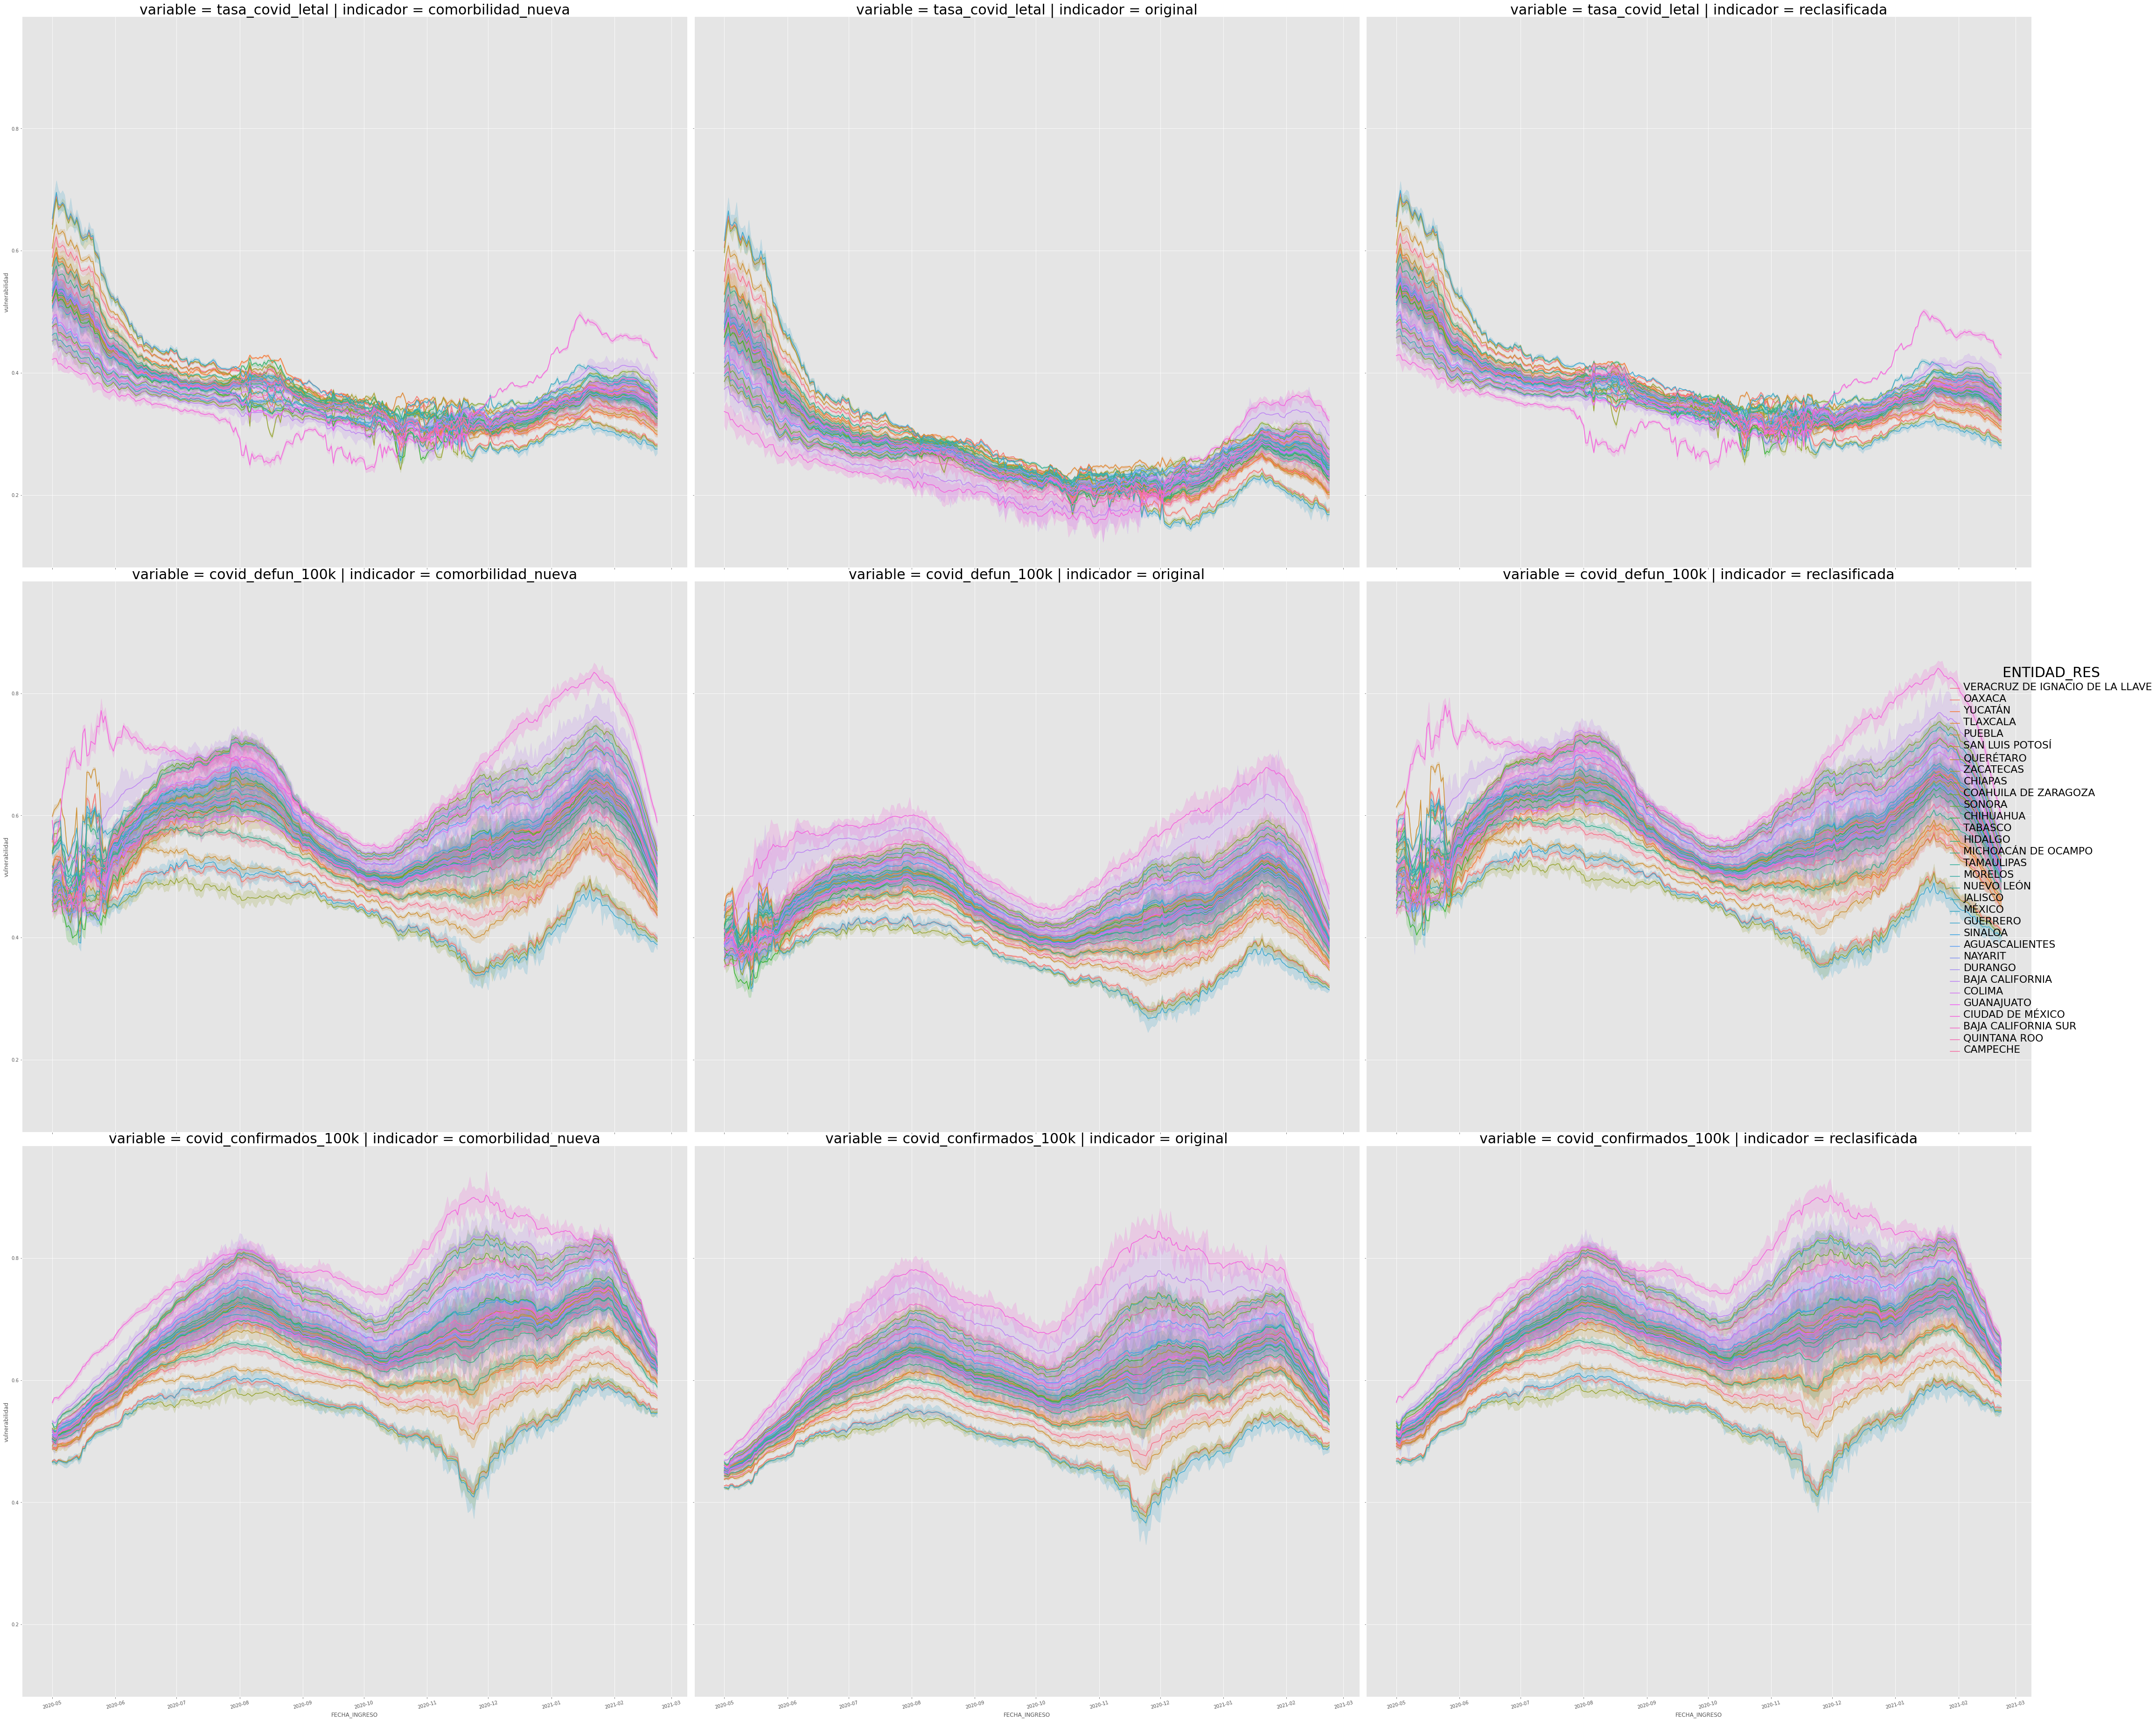

In [ ]:
g = sns.FacetGrid(series, col="indicador",row='variable', height=17, aspect=1.2,
                  hue="ENTIDAD_RES")
g.map(sns.lineplot, 'FECHA_INGRESO', "vulnerabilidad", palette='Spectral', n_boot=10)
g.set_xticklabels(rotation=15).add_legend()
g.set_titles(size=30)
plt.setp(g._legend.get_title(), fontsize=30)
plt.setp(g._legend.get_texts(), fontsize=22)
#g._legend.set_bbox_to_anchor((0.8, 0.25))
plt.savefig('img/comparacion_series_vulnerabilidad_variables.png', bbox_inches='tight')
plt.show()

In [ ]:
modelos['mediana'] = (modelos
                      .groupby(['caracteristica', 'indicador', 'variable'])['coef']
                      .transform('median'))
modelos.head()

caracteristica      coef dia_ajuste modelo           indicador  \
0        vul_ing -0.137723 2020-05-01    PLS  comorbilidad_nueva   
1       vnl_2015  0.291306 2020-05-01    PLS  comorbilidad_nueva   
2        an_2015  0.125112 2020-05-01    PLS  comorbilidad_nueva   
3       vpt_2015  0.102513 2020-05-01    PLS  comorbilidad_nueva   
4        pobreza  0.230264 2020-05-01    PLS  comorbilidad_nueva   

           variable   mediana  
0  tasa_covid_letal -0.017439  
1  tasa_covid_letal  0.078868  
2  tasa_covid_letal -0.013612  
3  tasa_covid_letal -0.089789  
4  tasa_covid_letal  0.097288

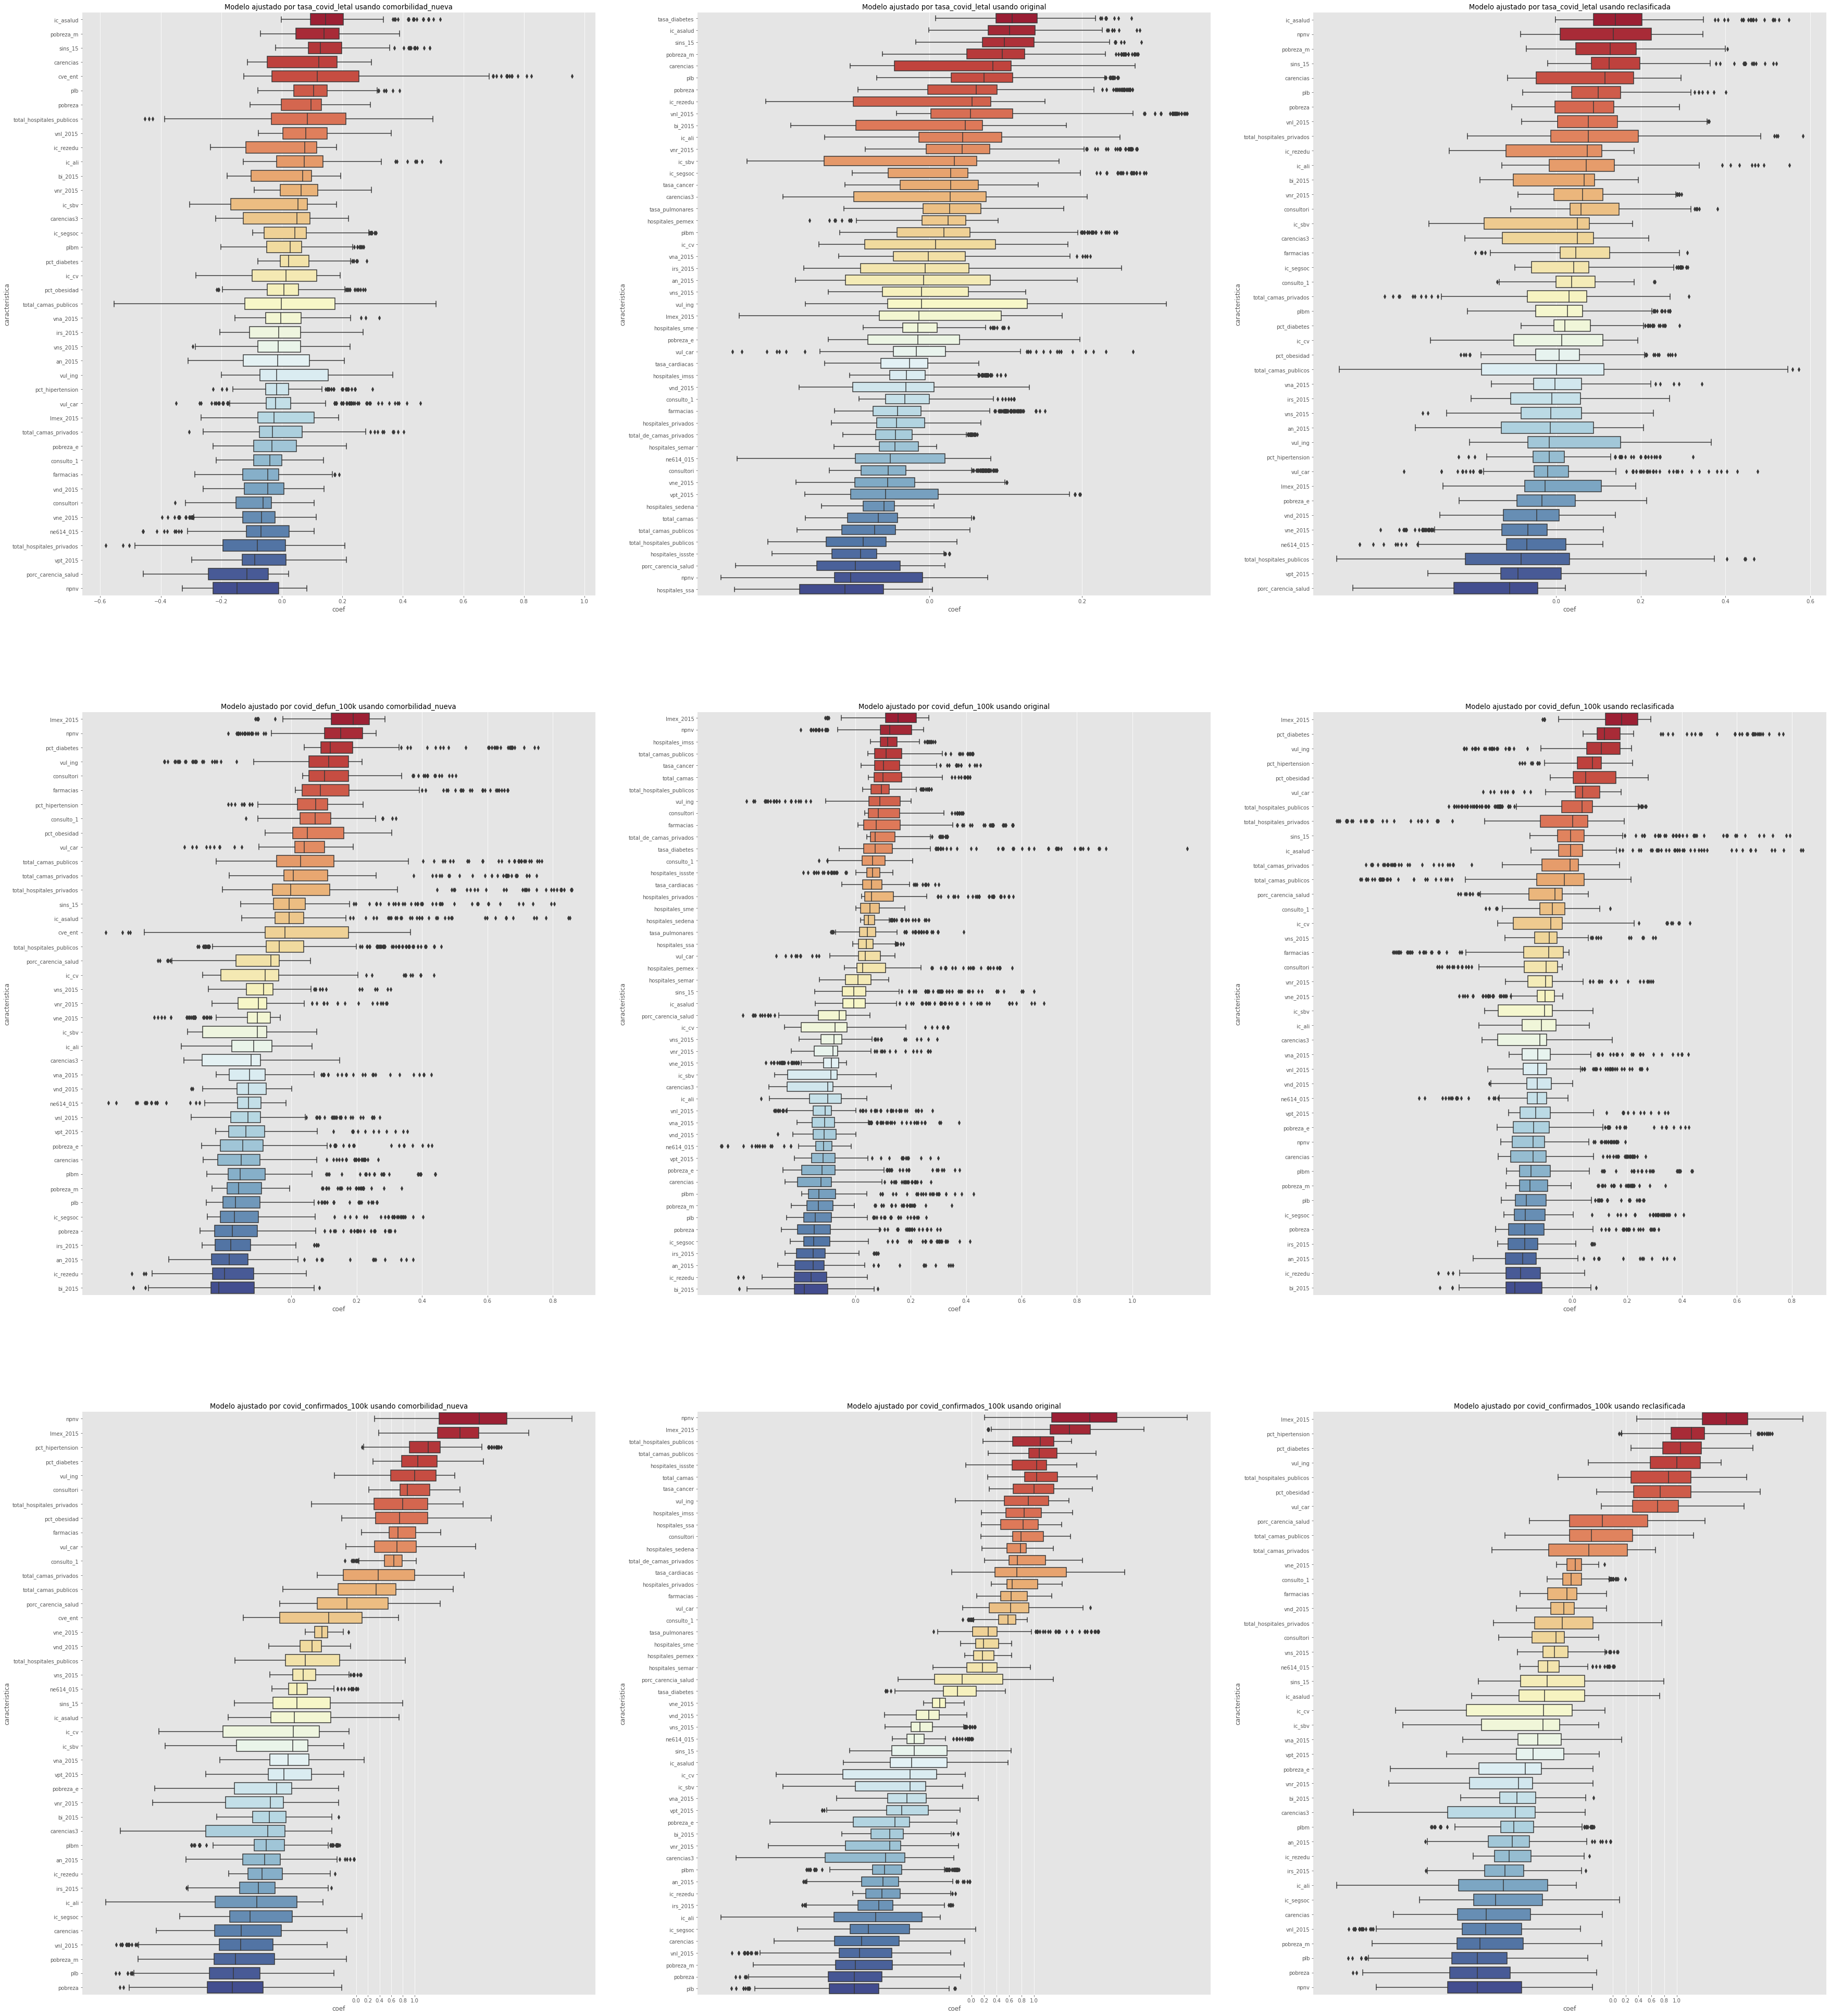

In [ ]:
f, axes = plt.subplots(3,3,figsize=(60, 70))
axes = axes.ravel()
ax_count = 0
sns.set(font_scale = 1.1)
for variable in variables:
    for indicador in indicadores.keys():
        datos = modelos[((modelos.indicador == indicador) & (modelos.variable == variable))]
        datos = datos.sort_values(by='mediana', ascending=False)
        b = sns.boxplot(y="caracteristica", x="coef",
            data=datos,
            palette='RdYlBu',
            ax=axes[ax_count])
        b.set_title(f'Modelo ajustado por {variable} usando {indicador}')
        sns.despine(trim=True, left=True)
        ax_count += 1
plt.savefig('img/comparacion_importancias_modelos_caracteristicas.png', bbox_inches='tight')